<a href="https://colab.research.google.com/github/ElizabethGhi/tools-for-remote-sensing-data-analysis/blob/main/ET_Download_%26_Time_Series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install --upgrade xee

In [3]:
!pip install --upgrade geemap

In [4]:
!pip install --upgrade netCDF4

In [5]:
import ee
import os
import geemap
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [7]:
geemap.ee_initialize()
ee.Initialize(opt_url='https://earthengine-highvolume.googleapis.com', project='ee-XXXXXXXXXX')

In [8]:
#LEER .nc DEL AREA DE ESTUDIO
path = "/gdrive/My Drive/GitHub/RemoteSensing_DataAnalysis"
area_estudio = xr.open_dataset(os.path.join(path, "NetCDF_CM/Poligonos_int.nc"))
area_estudio

<xarray.Dataset> Size: 84MB
Dimensions:  (lat: 1133, lon: 1233)
Coordinates:
  * lat      (lat) float64 9kB 20.19 20.19 20.19 20.19 ... 19.06 19.06 19.06
  * lon      (lon) float64 10kB -99.43 -99.43 -99.43 ... -98.2 -98.2 -98.2
Data variables:
    CM       (lat, lon) int32 6MB ...
    1507     (lat, lon) int64 11MB ...
    1319     (lat, lon) int64 11MB ...
    0901     (lat, lon) int64 11MB ...
    1320     (lat, lon) int64 11MB ...
    2902     (lat, lon) int64 11MB ...
    1506     (lat, lon) int64 11MB ...
    1508     (lat, lon) int64 11MB ...

In [9]:
#LEER DATASET DE EARTH ENGINE (MODIS)
start = '2001-01-01'
end   = '2021-12-31'
geometry = ee.Geometry.BBox(-99.466, 19, -98.133, 20.233)     #lon, lat del area rectangular que abarca el area de estudio
modis_ee = ee.ImageCollection("MODIS/061/MOD16A2GF").filterDate(start, end)
modis = xr.open_dataset(modis_ee, engine='ee', geometry=geometry, scale=0.003, fast_time_slicing=True)
modis_8days = modis[['ET', 'PET', 'ET_QC']]
modis_8days['ET'] = modis_8days['ET']* 0.1     #Factor de escala de la variable
modis_8days['PET'] = modis_8days['PET']* 0.1
modis_8days

<xarray.Dataset> Size: 2GB
Dimensions:  (time: 966, lon: 444, lat: 411)
Coordinates:
  * time     (time) datetime64[ns] 8kB 2001-01-01 2001-01-09 ... 2021-12-27
  * lon      (lon) float64 4kB -99.46 -99.46 -99.46 ... -98.14 -98.14 -98.14
  * lat      (lat) float64 3kB 19.0 19.0 19.01 19.01 ... 20.22 20.23 20.23 20.23
Data variables:
    ET       (time, lon, lat) float32 705MB 6.6 6.6 7.1 8.1 ... 12.3 10.6 13.6
    PET      (time, lon, lat) float32 705MB 34.2 34.1 34.2 ... 25.3 25.8 25.1
    ET_QC    (time, lon, lat) float32 705MB ...
Attributes:
    crs:      EPSG:4326

In [10]:
# Verificar los valores máximos y mínimos de una fecha
first_image = modis_8days["ET"].isel(time=0)
print(first_image.min().values, first_image.max().values)

5.099999904632568 23.399999618530273


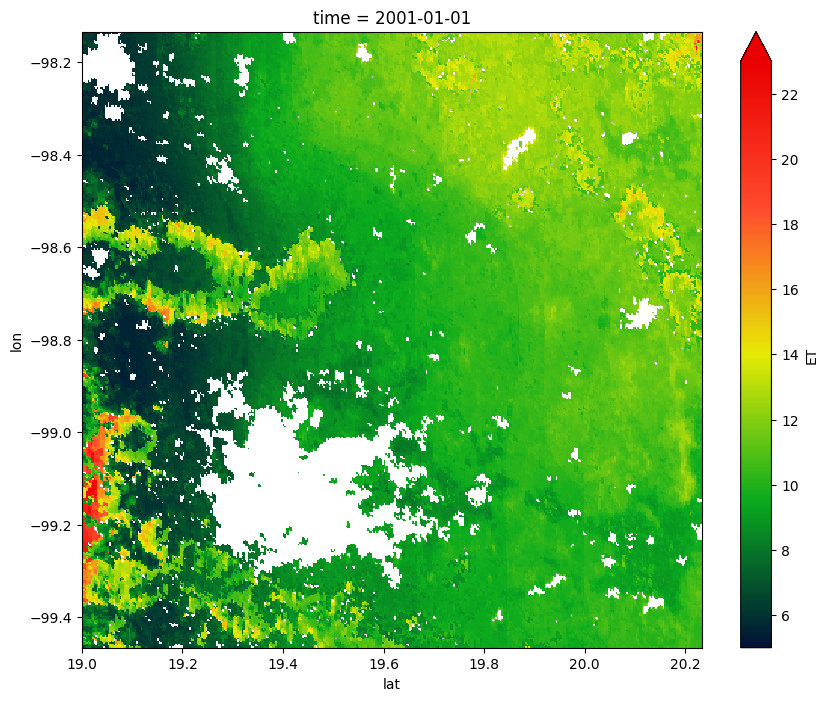

In [11]:
#VISUALIZAR LA IMAGEN DE UNA FECHA
colors = ['#001137', '#0aab1e', '#e7eb05', '#ff4a2d', '#e90000']
cmap = mcolors.LinearSegmentedColormap.from_list('continuous_palette', colors)
first_image.plot(figsize=(10, 8), cmap=cmap, vmin=5, vmax=23)
plt.show()

In [12]:
#RECORTAR EL DATASET EN EL AREA DE ESTUDIO
mascara_cm = area_estudio['CM']  # Reemplazar 'CM' si se desea recortar con otro poligono dentro del area de estudio
mascara_cm = mascara_cm.interp_like(modis, method='nearest')
# Aplicar la máscara al dataset
dataset_cm = modis_8days.where(mascara_cm == 1)
# Guardar .nc
output_path = os.path.join(path, "NetCDF_CM/MODIS_ET_8days_CM.nc")
dataset_cm.to_netcdf(output_path, engine="netcdf4")

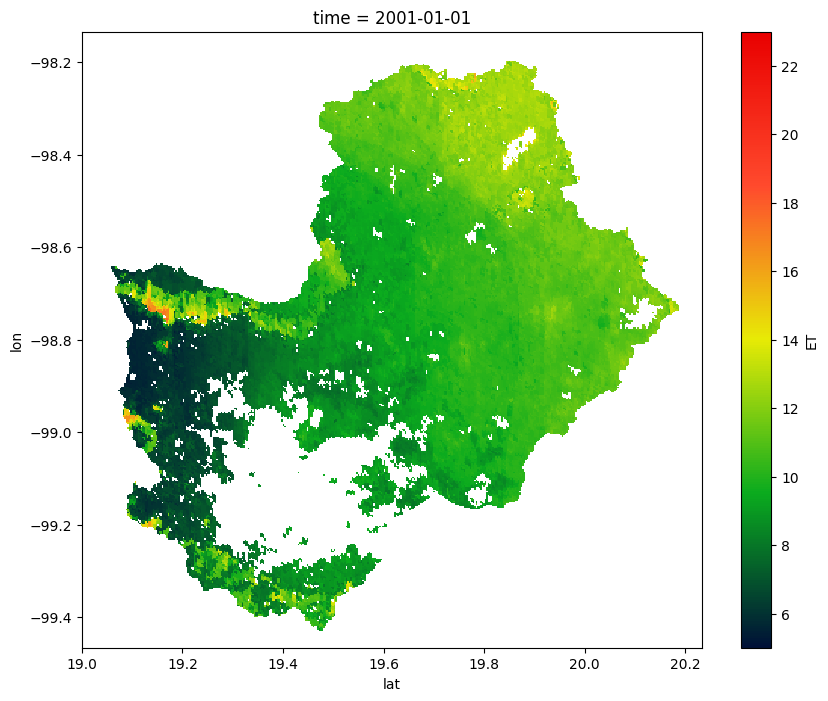

In [13]:
# Visualizar la imagen
image = dataset_cm["ET"].isel(time=0)
colors = ['#001137', '#0aab1e', '#e7eb05', '#ff4a2d', '#e90000']
cmap = mcolors.LinearSegmentedColormap.from_list('continuous_palette', colors)

fig, ax = plt.subplots(figsize=(10, 8))
image.plot(ax=ax, cmap=cmap, vmin=5, vmax=23)
plt.show()

##SERIES TEMPORALES

In [14]:
#Agregacion mensual y anual
modis_monthly = modis_8days.resample(time="1MS").mean()
modis_annual= modis_monthly.resample(time="YS").mean()

#Guardar
modis_monthly.to_netcdf(os.path.join(path, "NetCDF_CM/MODIS_ETP_Monthly_CM.nc"))
modis_annual.to_netcdf(os.path.join(path, "NetCDF_CM/MODIS_ETP_Annual_CM.nc"))
modis_monthly

<xarray.Dataset> Size: 552MB
Dimensions:  (time: 252, lon: 444, lat: 411)
Coordinates:
  * lon      (lon) float64 4kB -99.46 -99.46 -99.46 ... -98.14 -98.14 -98.14
  * lat      (lat) float64 3kB 19.0 19.0 19.01 19.01 ... 20.22 20.23 20.23 20.23
  * time     (time) datetime64[ns] 2kB 2001-01-01 2001-02-01 ... 2021-12-01
Data variables:
    ET       (time, lon, lat) float32 184MB 6.125 6.0 6.925 ... 17.65 19.77
    PET      (time, lon, lat) float32 184MB 39.28 39.18 38.98 ... 32.88 32.45
    ET_QC    (time, lon, lat) float32 184MB 0.0 2.0 0.0 2.0 ... 0.0 0.0 0.0 8.0
Attributes:
    crs:      EPSG:4326

In [15]:
# Inicializar diccionarioS para almacenar las series temporales
series_mensuales_ET= {}
series_anuales_ET= {}
series_mensuales_ETP= {}
series_anuales_ETP= {}

# Iterar sobre cada poligono en 'area_estudio' y generar una mascara
for idx, nombre_area in enumerate(area_estudio.data_vars):
    mascara = area_estudio[nombre_area]
    mascara_interpolada = mascara.interp_like(modis_monthly, method='nearest')

    # Aplicar la mascara
    mask_prec_monthly = modis_monthly.where(mascara_interpolada == 1)
    mask_prec_annual = modis_annual.where(mascara_interpolada == 1)

    # Calcular la media espacial a lo largo de las dimensiones de latitud y longitud
    MODIS_mean_sp_monthly_ET = mask_prec_monthly['ET'].mean(dim=('lon', 'lat'))
    MODIS_mean_sp_annual_ET = mask_prec_annual['ET'].mean(dim=('lon', 'lat'))

    MODIS_mean_sp_monthly_ETP = mask_prec_monthly['PET'].mean(dim=('lon', 'lat'))
    MODIS_mean_sp_annual_ETP = mask_prec_annual['PET'].mean(dim=('lon', 'lat'))

    # Obtener los valores y las fechas como un array de NumPy
    mean_monthly_ET = MODIS_mean_sp_monthly_ET .values
    time_monthly_ET = MODIS_mean_sp_monthly_ET ['time'].values
    mean_annual_ET = MODIS_mean_sp_annual_ET.values
    time_annual_ET = MODIS_mean_sp_annual_ET['time'].values

    mean_monthly_ETP = MODIS_mean_sp_monthly_ETP .values
    time_monthly_ETP = MODIS_mean_sp_monthly_ETP ['time'].values
    mean_annual_ETP = MODIS_mean_sp_annual_ETP.values
    time_annual_ETP= MODIS_mean_sp_annual_ETP['time'].values

    # Almacenar la serie temporal en el diccionario
    series_mensuales_ET [nombre_area] = mean_monthly_ET
    series_anuales_ET [nombre_area] = mean_annual_ET

    series_mensuales_ETP [nombre_area] = mean_monthly_ETP
    series_anuales_ETP [nombre_area] = mean_annual_ETP

# Convertir el diccionario en un DataFrame con indice de fechas
df_series_mensuales_ET = pd.DataFrame(series_mensuales_ET, index=pd.to_datetime(time_monthly_ET))
df_series_mensuales_ET.index.name = 'Fecha'
df_series_anuales_ET = pd.DataFrame(series_anuales_ET, index=pd.to_datetime(time_annual_ET))
df_series_anuales_ET.index.name = 'Fecha'

df_series_mensuales_ETP = pd.DataFrame(series_mensuales_ETP, index=pd.to_datetime(time_monthly_ETP))
df_series_mensuales_ETP.index.name = 'Fecha'
df_series_anuales_ETP = pd.DataFrame(series_anuales_ETP, index=pd.to_datetime(time_annual_ETP))
df_series_anuales_ETP.index.name = 'Fecha'

# Guardar el DataFrame en un archivo CSV
df_series_mensuales_ET.to_csv(os.path.join(path, "Series/ET/Series_MODIS-ET_monthly.csv"))
df_series_anuales_ET.to_csv(os.path.join(path, "Series/ET/Series_MODIS-ET_annual.csv"))
df_series_mensuales_ETP.to_csv(os.path.join(path, "Series/ET/Series_MODIS-PET_monthly.csv"))
df_series_anuales_ETP.to_csv(os.path.join(path, "Series/ET/Series_MODIS-PET_annual.csv"))

print(f"Se han generado las series temporales")

Se han generado las series temporales


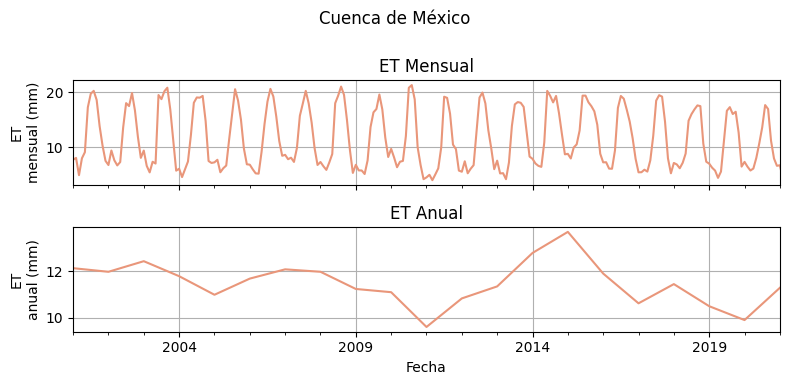

In [70]:
# GRAFICAS MENSUALES Y ANUALES ET MEDIA DE LA CUENCA DE MEXICO
fig, axes = plt.subplots(2, 1, figsize=(8, 4), sharex=True)

# Precipitación mensual
df_series_mensuales_ET["CM"].plot(ax=axes[0], color="darksalmon", legend=False)
axes[0].set_ylabel("ET\nmensual (mm)")
axes[0].set_title("ET Mensual")
axes[0].grid(True)

# Precipitación anual
df_series_anuales_ET["CM"].plot(ax=axes[1], color="darksalmon", legend=False)
axes[1].set_ylabel("ET\nanual (mm)")
axes[1].set_title("ET Anual")
axes[1].grid(True)

fig.suptitle("Cuenca de México", fontsize=12, y=0.95)
fig.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

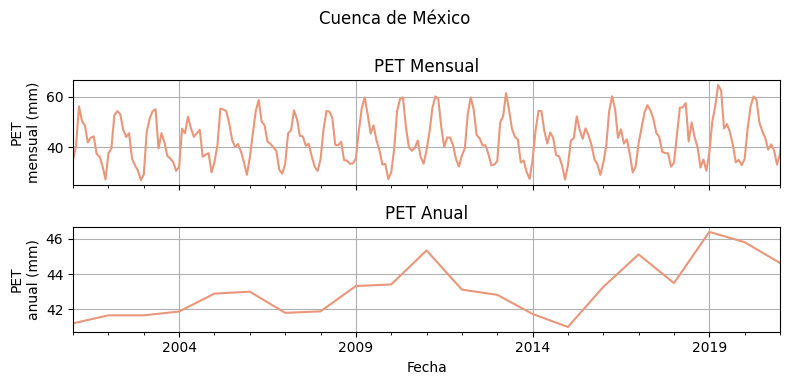

In [71]:
# GRAFICAS MENSUALES Y ANUALES PET MEDIA DE LA CUENCA DE MEXICO
fig, axes = plt.subplots(2, 1, figsize=(8, 4), sharex=True)

# Precipitación mensual
df_series_mensuales_ETP["CM"].plot(ax=axes[0], color="darksalmon", legend=False)
axes[0].set_ylabel("PET\nmensual (mm)")
axes[0].set_title("PET Mensual")
axes[0].grid(True)

# Precipitación anual
df_series_anuales_ETP["CM"].plot(ax=axes[1], color="darksalmon", legend=False)
axes[1].set_ylabel("PET\nanual (mm)")
axes[1].set_title("PET Anual")
axes[1].grid(True)

fig.suptitle("Cuenca de México", fontsize=12, y=0.95)
fig.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

##Series mensuales desde un achivo.csv

In [89]:
#Importar serie 8 days PET MOD16A2 de ClimateEngine (csv)
ClimateEngine_ETP = pd.read_csv(os.path.join(path, "Series/ET/MODIS_PET_ClimateEngine.csv"), index_col=0, parse_dates=[0])
ClimateEngine_ETP.head(2)

,PET
Fecha,
01/01/2001,32.3576
09/01/2001,36.2729


In [90]:
# Remuestrear a escala mensual tomando el promedio
ClimateEngine_ETP.index = pd.to_datetime(ClimateEngine_ETP.index, format='%d/%m/%Y') # Asegurar el indice como datetime
ClimateEngine_ETP_mensual_mean = ClimateEngine_ETP.resample('MS').mean()
ClimateEngine_ETP_anual_mean = ClimateEngine_ETP.resample('YS').mean()

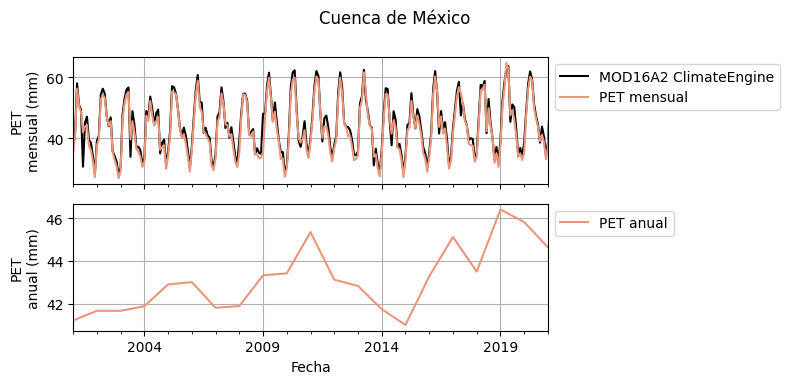

In [91]:
# COMPARACION DE SERIES TEMPORALES PET DE LA CUENCA DE MEXICO
fig, axes = plt.subplots(2, 1, figsize=(8, 4), sharex=True)

# PET mensual Climate Engine de agregacion de serie.csv
ClimateEngine_ETP_mensual_mean.plot(ax=axes[0], color="black", legend=True)
axes[0].set_ylabel("PET\nmensual (mm)")
axes[0].grid(True)

# PET mensual
df_series_mensuales_ETP["CM"].plot(ax=axes[0], color="darksalmon", legend=True)
axes[0].set_ylabel("PET\nmensual (mm)")
axes[0].grid(True)

#Comparacion con las series mensuales de agregacion en dataset.nc
# PET anual
df_series_anuales_ETP["CM"].plot(ax=axes[1], color="darksalmon", legend=True)
axes[1].set_ylabel("PET\nanual (mm)")
axes[1].grid(True)

# Cambiar la leyenda después de haberla generado
axes[0].legend(labels=["MOD16A2 ClimateEngine", "PET mensual"], loc='upper left', bbox_to_anchor=(1, 1))
axes[1].legend(labels=["PET anual"], loc='upper left', bbox_to_anchor=(1, 1))

fig.suptitle("Cuenca de México", fontsize=12, y=0.95)
fig.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


In [92]:
# Remuestrear a escala mensual tomando la suma
ClimateEngine_ETP.index = pd.to_datetime(ClimateEngine_ETP.index, format='%d/%m/%Y') # Asegurar el indice como datetime
ClimateEngine_ETP_mensual_sum = ClimateEngine_ETP.resample('MS').sum()
ClimateEngine_ETP_anual_sum = ClimateEngine_ETP.resample('YS').sum()

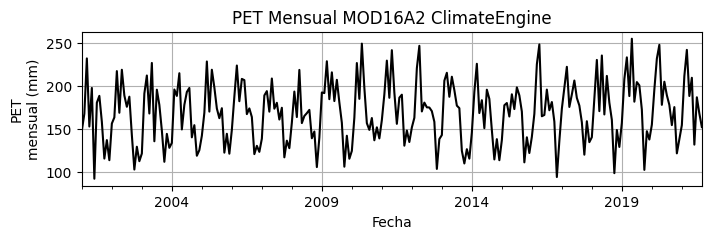

In [93]:
# GRAFICAS MENSUALES DE LA SUMA DE PET DE LA CUENCA DE MEXICO
fig, ax = plt.subplots(figsize=(8, 2))
ClimateEngine_ETP_mensual_sum.plot(color="black", ax=ax, legend=False)

ax.set_ylabel("PET\nmensual (mm)")
ax.set_title("PET Mensual MOD16A2 ClimateEngine")
ax.grid(True)